1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

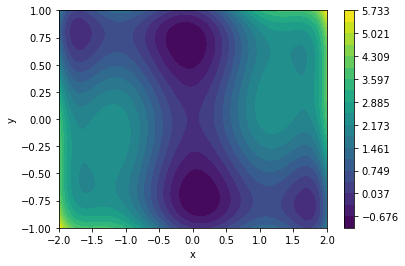

First global minima found at:
[-0.08984202  0.71265642]
with:
f(X) = -1.0316284534898756


Second global minima found at:
[ 0.08984201 -0.71265643]
with:
f(X) = -1.0316284534898703


Results with initial guess (0, 0):
      fun: 0.0
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ 5.96046448e-08, -5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])

which is a local minima


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats

def f(X):
    return ( (4.-2.1*X[0]**2+X[0]**4/3)*X[0]**2+X[0]*X[1]+(4*X[1]**2-4)*X[1]**2 )

def print_fun(x, f, accepted):
    print("at minimum %.4f accepted %d" % (f, int(accepted)))

x = np.linspace(-2, 2, 500)
y = np.linspace(-1, 1, 500)
xx, yy = np.meshgrid(x, y)
Z = f((xx, yy))
levels = np.linspace(Z.min(), Z.max(), 20)
plt.contourf(xx, yy, Z, levels=levels)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

min_res = (optimize.minimize(f, x0=(0, 2)), optimize.minimize(f, x0=(0, -2)))
print('First global minima found at:',min_res[0].x, 'with:', 'f(X) = ' + str(min_res[0].fun), '\n', sep='\n')
print('Second global minima found at:',min_res[1].x, 'with:', 'f(X) = ' + str(min_res[1].fun), '\n', sep='\n')

min_res0 = optimize.minimize(f, x0=(0, 0))
print('Results with initial guess (0, 0):', min_res0, '\nwhich is a local minima', sep='\n')

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

Parameters of fitting: 
	mean	sigma		offset		scale
max:
[  5.73581633   2.29443576  15.77931949 132.80946074]
min:
[  6.16452591   1.97590029 -61.32093822 260.76391895]


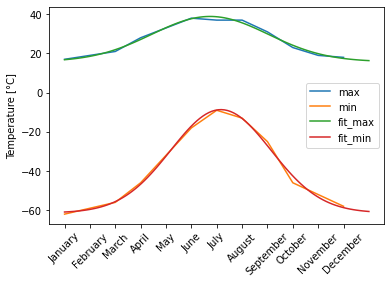

Covariance matrices
max:
[[ 6.31513587e-03 -2.12225635e-04  1.91641358e-03 -2.15104219e-02]
 [-2.12225635e-04  2.75437872e-02 -1.70932568e-01  2.17795482e+00]
 [ 1.91641358e-03 -1.70932568e-01  1.38431401e+00 -1.61250343e+01]
 [-2.15104219e-02  2.17795482e+00 -1.61250343e+01  2.03798230e+02]]
min:
[[ 2.22850086e-03 -4.92556161e-05  1.09102311e-03 -1.08267273e-02]
 [-4.92556161e-05  5.77328349e-03 -7.06521666e-02  8.74435887e-01]
 [ 1.09102311e-03 -7.06521666e-02  1.41331087e+00 -1.45310828e+01]
 [-1.08267273e-02  8.74435887e-01 -1.45310828e+01  1.78561016e+02]]

the fit is reasonable, the time offset is not the same within the fit accuracy


In [2]:
import math
t_max = np.asarray((17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18))
t_min = np.asarray((-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58))
months = [ 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
x = np.arange(0, 12, 1)
plt.plot(x, t_max, label='max')
plt.plot(x, t_min, label='min')
plt.xticks(x, months, rotation=45)
plt.ylabel('Temperature [°C]')

def gauss(x, mean, sigma, offset, k):
    return k*(sigma*(2*math.pi)**0.5)**-1*np.exp(-(x-mean)**2/(2*sigma**2)) + offset

max_popt, max_pcov = optimize.curve_fit(gauss, x, t_max, p0=(6, 4, 20, 40), bounds=([0,0,0,0], [12,12,40,200]))
min_popt, min_pcov = optimize.curve_fit(gauss, x, t_min, p0=(6, 4, -70, 60), bounds=([0,0,-100,0], [12,12,0,400]))
#redefine x to plot smoother functions
x = np.linspace(0, 12, 100)
print("Parameters of fitting: ", "\tmean\tsigma\t\toffset\t\tscale\nmax:", max_popt, 'min:', min_popt, sep='\n')

plt.plot(x, gauss(x, max_popt[0], max_popt[1], max_popt[2], max_popt[3]), label = 'fit_max')
plt.plot(x, gauss(x, min_popt[0], min_popt[1], min_popt[2], min_popt[3]), label = 'fit_min')
plt.legend()
plt.show()
print("Covariance matrices", "max:", max_pcov, "min:", min_pcov, sep='\n')
print("\nthe fit is reasonable, the time offset is not the same within the fit accuracy")

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

Parameters of fitting: 
	mean	sigma		offset		scale:
[-6.87236210e-02  6.71559633e-01  1.00000000e-01  1.69984897e+04]

Covariance matrix
[[ 2.00661042e-04  8.36551251e-05 -2.03143367e-03  4.48059509e-01]
 [ 8.36551251e-05  4.85046555e-05 -1.85457119e-03  4.91984183e-01]
 [-2.03143367e-03 -1.85457119e-03  5.20093495e+00 -3.68826096e+01]
 [ 4.48059509e-01  4.91984183e-01 -3.68826096e+01  9.40184120e+03]]


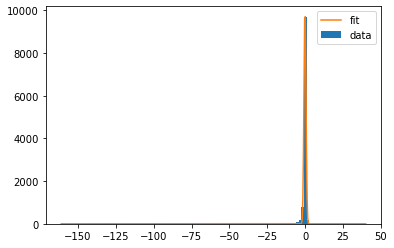

n degrees of freedom = 46
chi2 = 100.64667105419579
p-value = 5.91669592597821e-06


In [3]:

data = np.load("data/residuals_261.pkl", allow_pickle=True)
n, bins, _ = plt.hist(data[()]['residuals'], 100, label = 'data')
mask = n != 0
sigma = np.sqrt(n[mask])
hist_popt, hist_pcov = optimize.curve_fit(gauss, bins[0:-1]+(bins[-1]-bins[-2])/2, n, p0=(0, 2, 0, 20000), bounds=([-10,0,-0.1,0], [10,10,0.1,np.inf]))
print("Parameters of fitting: ", "\tmean\tsigma\t\toffset\t\tscale:", hist_popt, sep='\n')
print("\nCovariance matrix", hist_pcov, sep='\n')
x = np.linspace(-161, 40, 500)
plt.plot(x, gauss(x, hist_popt[0], hist_popt[1], hist_popt[2], hist_popt[3]), label = 'fit')
plt.legend()
plt.show()
ndof = len(sigma) - 1
print("n degrees of freedom =", ndof)
# calculate the chi^2
bins=bins[:-1]
chi2 = np.sum((n[n != 0] - gauss(bins[mask]+(bins[-1]-bins[-2])/2, hist_popt[0], hist_popt[1], hist_popt[2], hist_popt[3])) / sigma)
print("chi2 =", chi2)
# calculate the p-value from the chi^2, the n.d.o.f., and the comulative chi^2 distribution
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value =", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory


4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.

In [41]:
def f(t, a, b, c):
    return a*np.cos(2*math.pi*t + b) + c

def g(t, a, b, c, d):
    return a*np.cos(2*math.pi*b*t + c) + d

#as in notes
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL


Parameters of fitting: 
	a	b	c
[9.67127679 2.91793939 9.05256209]

Covariance matrix
[[ 3.10356272e-02  3.05683134e-05  3.52680253e-04]
 [ 3.05683134e-05  3.34198691e-04 -2.60807354e-05]
 [ 3.52680253e-04 -2.60807354e-05  1.55751793e-02]]


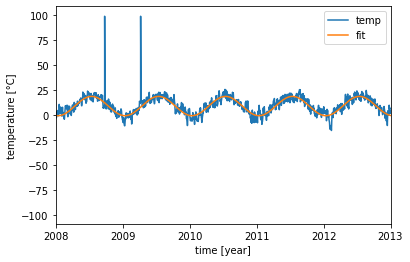

Overall average: 8.941907038598593
daily average hottest: 18.723638518715518 
coldest: -0.6187147008618226


In [34]:
import pandas as pd

df = pd.read_csv('data/munich_temperatures_average_with_bad_data.txt', sep = ' ', names = ('time', 'temp'))
df.plot(x='time', y='temp', xlim=(2008, 2013))
plt.ylabel('temperature [°C]')
plt.xlabel('time [year]')

f_popt, f_pcov = optimize.curve_fit( f, df['time'], df['temp'], p0=(10, 0, 10), bounds=([0, 0, 0], [20, 4, 20]))
print("Parameters of fitting: ", "\ta\tb\tc", f_popt, sep='\n')
print("\nCovariance matrix", f_pcov, sep='\n')
plt.plot(df[df['time'] > 2008]['time'], f(df[df['time'] > 2008]['time'], f_popt[0], f_popt[1], f_popt[2]), label='fit')
plt.legend()
plt.show()
f_predict = f(df['time'], f_popt[0], f_popt[1], f_popt[2])
print('Overall average:', stats.tmean(df['temp']))
print('daily average hottest:', f_predict.max(), '\ncoldest:', f_predict.min())


The "b" parameter represents the x shift of the cosine function in terms of radiants.
Physically it express what is the time of the year with the hottest temperature, in fact if we divide it by $2*\pi$ and subtract it to $1$ we obtain $\sim 0.54$ which corresponds to summer (half of July).

In [46]:
g_popt, g_pcov = optimize.curve_fit( g, df['time'], df['temp'], p0=(10, 1, 4, 10), bounds=([0, 0, 0, 0], [20, 5, 10, 20]))
print("Parameters of fitting: ", "\ta\tb\tc\t\td", g_popt, sep='\n')
print("\nCovariance matrix", g_pcov, sep='\n')

g_predict = g(df['time'], g_popt[0], g_popt[1], g_popt[2], g_popt[3])
f_rss = np.sum((f_predict - df['temp'])**2)
g_rss = np.sum((g_predict - df['temp'])**2)
print("\nRSS for f:", f_rss, "\nfor g:", g_rss, '\n')
print('F-test:')
cl = Ftest(f_rss, g_rss, 2, 3, df.size, True)

Parameters of fitting: 
	a	b	c		d
[9.67159516 0.99973982 6.19442201 9.05135312]

Covariance matrix
[[ 3.10799279e-02  3.52705015e-06 -4.43834256e-02  3.65241182e-04]
 [ 3.52705015e-06  3.04517921e-07 -3.83462749e-03  1.41615038e-06]
 [-4.43834256e-02 -3.83462749e-03  4.82876991e+01 -1.78585808e-02]
 [ 3.65241182e-04  1.41615038e-06 -1.78585808e-02  1.55834328e-02]]

RSS for f: 694209.8326248894 
for g: 694186.2523450397 

F-test:
CL: 0.501 , additional parameter necessary: NO
